In [26]:
from tensorflow.keras.utils import image_dataset_from_directory


In [27]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("smaranjitghose/corn-or-maize-leaf-disease-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\gharr\.cache\kagglehub\datasets\smaranjitghose\corn-or-maize-leaf-disease-dataset\versions\1


In [28]:

data = f"{path}/data"
import tensorflow as tf
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    data,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=42
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    data,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=42
)

class_names = train_ds_raw.class_names

print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds_raw.map(lambda x, y: (x/255.0, y)).cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds_raw.map(lambda x, y: (x/255.0, y)).cache().prefetch(AUTOTUNE)



Found 4188 files belonging to 4 classes.
Using 3351 files for training.
Found 4188 files belonging to 4 classes.
Using 837 files for validation.
Classes: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [29]:
import tensorflow as tf

# Find the index of the Healthy class
healthy_idx = class_names.index("Healthy")
print("Healthy class index:", healthy_idx)

def filter_unhealthy(images, labels):
    # Create a mask for labels != healthy
    mask = tf.not_equal(labels, healthy_idx)

    # Select only the unhealthy samples from the batch
    images = tf.boolean_mask(images, mask)
    labels = tf.boolean_mask(labels, mask)

    return images, labels

# Apply filtering AND normalization
train_unhealthy = (
    train_ds_raw
    .map(filter_unhealthy)
    .map(lambda x, y: (x/255.0, y))
    .cache()
    .shuffle(1000)
    .prefetch(tf.data.AUTOTUNE)
)

val_unhealthy = (
    val_ds_raw
    .map(filter_unhealthy)
    .map(lambda x, y: (x/255.0, y))
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)




Healthy class index: 3


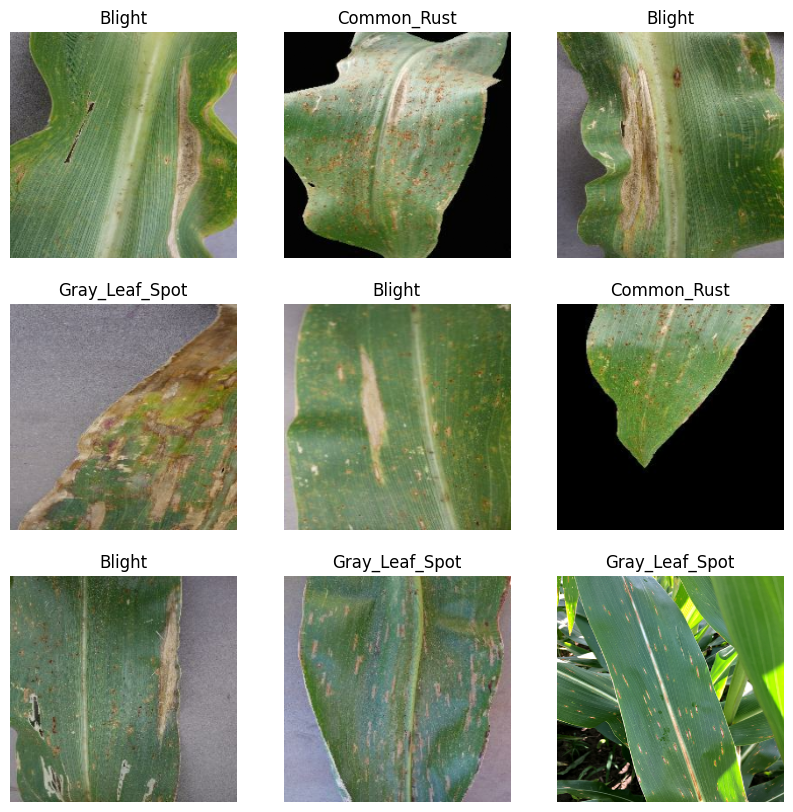

In [30]:
import matplotlib.pyplot as plt

for images, labels in train_unhealthy.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
    break


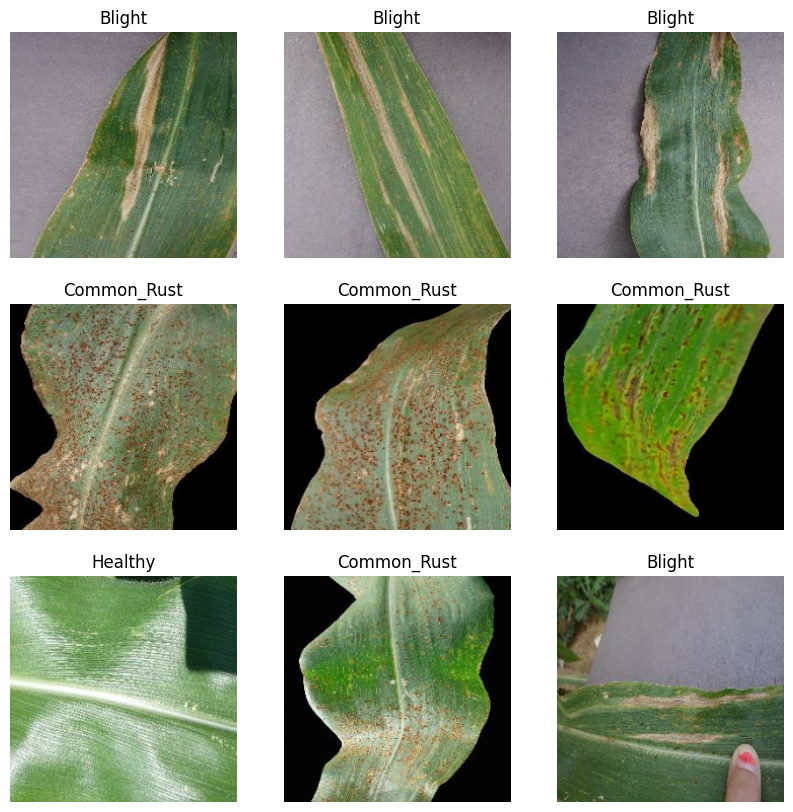

In [31]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
    break


In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)


In [33]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False  # freeze base layers for faster training


In [34]:

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10)


Epoch 1/10


105/105 ━━━━━━━━━━━━━━━━━━━━ 70s 587ms/step - accuracy: 0.8747 - loss: 0.3148 - val_accuracy: 0.9235 - val_loss: 0.2173
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 60s 570ms/step - accuracy: 0.9364 - loss: 0.1647 - val_accuracy: 0.9259 - val_loss: 0.2108
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 58s 558ms/step - accuracy: 0.9493 - loss: 0.1241 - val_accuracy: 0.9271 - val_loss: 0.2267
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 55s 524ms/step - accuracy: 0.9606 - loss: 0.0992 - val_accuracy: 0.9295 - val_loss: 0.2026
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 58s 552ms/step - accuracy: 0.9743 - loss: 0.0711 - val_accuracy: 0.9271 - val_loss: 0.2058
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 56s 535ms/step - accuracy: 0.9833 - loss: 0.0554 - val_accuracy: 0.9200 - val_loss: 0.2378
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 56s 531ms/step - accuracy: 0.9869 - loss: 0.0399 - val_accuracy: 0.9140 - val_loss: 0.2546
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 56s 534ms/step - accuracy: 0.9899 - loss: 0.0350 - val

In [35]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # very low LR
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history += model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)





Epoch 1/5


105/105 ━━━━━━━━━━━━━━━━━━━━ 62s 546ms/step - accuracy: 0.9991 - loss: 0.0105 - val_accuracy: 0.9271 - val_loss: 0.2493
Epoch 2/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 55s 523ms/step - accuracy: 0.9991 - loss: 0.0092 - val_accuracy: 0.9307 - val_loss: 0.2490
Epoch 3/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 55s 523ms/step - accuracy: 0.9994 - loss: 0.0085 - val_accuracy: 0.9319 - val_loss: 0.2491
Epoch 4/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 55s 522ms/step - accuracy: 0.9994 - loss: 0.0080 - val_accuracy: 0.9307 - val_loss: 0.2495
Epoch 5/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 56s 536ms/step - accuracy: 0.9994 - loss: 0.0077 - val_accuracy: 0.9307 - val_loss: 0.2499


TypeError: unsupported operand type(s) for +=: 'History' and 'History'

In [ ]:
print(class_names)

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
Y_pred = model.predict(val_ds)
y_pred = np.argmax(Y_pred, axis=1)

# Extract true labels from the dataset
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# If one-hot encoded labels:
if y_true.ndim > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))
# Optional: confusion matrix
print(confusion_matrix(y_true, y_pred))


27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 455ms/step
                precision    recall  f1-score   support

        Blight       0.90      0.88      0.89       225
   Common_Rust       0.97      0.95      0.96       244
Gray_Leaf_Spot       0.79      0.86      0.82       126
       Healthy       1.00      1.00      1.00       242

      accuracy                           0.93       837
     macro avg       0.92      0.92      0.92       837
  weighted avg       0.93      0.93      0.93       837

[[197   3  24   1]
 [  7 233   4   0]
 [ 14   4 108   0]
 [  1   0   0 241]]



        Blight       0.90      0.88      0.89       225
   Common_Rust       0.97      0.95      0.96       244
Gray_Leaf_Spot       0.79      0.86      0.82       126
       Healthy       1.00      1.00      1.00       242

      accuracy                           0.93       837
     macro avg       0.92      0.92      0.92       837
  weighted avg       0.93      0.93      0.93       837

[[197   3  24   1]
 [  7 233   4   0]
 [ 14   4 108   0]
 [  1   0   0 241]]

In [ ]:
#want to get just accuracy from model
loss, accuracy = model.evaluate(val_ds)
print("Validation Accuracy:", accuracy)
print('Loss:', loss)

27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 432ms/step - accuracy: 0.9307 - loss: 0.2487
Validation Accuracy: 0.9307048916816711
Loss: 0.24869751930236816


In [ ]:
import json

with open("MobileNetV2_training_history.json", "w") as f:
    json.dump(combined_history, f)



In [ ]:
np.save("MobileNetV2_history_fine.npy", history.history) # Export 